In [ ]:
#从源数据文件提取并处理为18个指标：高压、低压以及合计新装增容、新装（户数、容量），然后加工出高压、低压以及合计增容（户数、容量）
#该块代码转为处理新装增容数据

import pandas as pd
import os
import re
from pathlib import Path
from typing import List, Dict, Optional
import traceback

# ==============================================================================
# 1. 配置层 (Configuration Layer)
# ==============================================================================
class Config:
    """集中管理所有可配置参数"""
    INPUT_DIR = Path(r'E:\A智网\业扩分析\数据准备\新装增容数据')
    OUTPUT_FILE = Path(r'E:\A智网\业扩分析\8月分析\7月业扩月度报告\25年7月业扩报告_新装增容业扩.xlsx') # 建议新文件名以防覆盖
    FILENAME_PATTERN = r'^\d{6}\.xlsx$'

    TARGET_SHEET_NAME = '国网湖北省电力有限公司'
    SKIP_ROWS = 3
    HEADER_ROWS_COUNT = 4

    ### 重构/新增开始 ###

    # --- 核心指标的最终命名 ---
    # Part 1: 从源文件直接提取的指标 (栏目 13-24)

    # 1.1 完成新装增容 (合计)
    COL_TOTAL_ALL_COUNT     = '完成新装增容_户数'
    COL_TOTAL_ALL_CAPACITY  = '完成新装增容_容量'

    # 1.2 完成新装增容 (高压)
    COL_TOTAL_HV_COUNT      = '高压完成新装增容_户数'
    COL_TOTAL_HV_CAPACITY   = '高压完成新装增容_容量'

    # 1.3 完成新装增容 (低压)
    COL_TOTAL_LV_COUNT      = '低压完成新装增容_户数'
    COL_TOTAL_LV_CAPACITY   = '低压完成新装增容_容量'

    # 1.4 完成新装 (合计)
    COL_NEW_ALL_COUNT       = '完成新装_户数'
    COL_NEW_ALL_CAPACITY    = '完成新装_容量'

    # 1.5 完成新装 (高压)
    COL_NEW_HV_COUNT        = '高压完成新装_户数'
    COL_NEW_HV_CAPACITY     = '高压完成新装_容量'

    # 1.6 完成新装 (低压)
    COL_NEW_LV_COUNT        = '低压完成新装_户数'
    COL_NEW_LV_CAPACITY     = '低压完成新装_容量'


    # Part 2: 通过计算生成的衍生指标 (增容 = 新装增容 - 新装)

    # 2.1 完成增容 (合计)
    COL_INC_ALL_COUNT       = '完成增容_户数'
    COL_INC_ALL_CAPACITY    = '完成增容_容量'

    # 2.2 完成增容 (高压)
    COL_INC_HV_COUNT        = '高压完成增容_户数'
    COL_INC_HV_CAPACITY     = '高压完成增容_容量'

    # 2.3 完成增容 (低压)
    COL_INC_LV_COUNT        = '低压完成增容_户数'
    COL_INC_LV_CAPACITY     = '低压完成增容_容量'

    ### 重构/新增结束 ###

    @staticmethod
    def get_sheets_to_create() -> Dict[str, str]:
        """
        定义要创建的所有工作表。
        字典的键 (key) 是最终Excel中的工作表名称。
        字典的值 (value) 是 long_df 中对应的数据列名。
        此方法现在将返回所有18个指标的工作表定义。
        """
        ### 重构/新增开始 ###
        sheets = {
            # 新装增容 (合计)
            Config.COL_TOTAL_ALL_COUNT:    Config.COL_TOTAL_ALL_COUNT,
            Config.COL_TOTAL_ALL_CAPACITY: Config.COL_TOTAL_ALL_CAPACITY,
            # 新装增容 (高压)
            Config.COL_TOTAL_HV_COUNT:     Config.COL_TOTAL_HV_COUNT,
            Config.COL_TOTAL_HV_CAPACITY:  Config.COL_TOTAL_HV_CAPACITY,
            # 新装增容 (低压)
            Config.COL_TOTAL_LV_COUNT:     Config.COL_TOTAL_LV_COUNT,
            Config.COL_TOTAL_LV_CAPACITY:  Config.COL_TOTAL_LV_CAPACITY,

            # 新装 (合计)
            Config.COL_NEW_ALL_COUNT:      Config.COL_NEW_ALL_COUNT,
            Config.COL_NEW_ALL_CAPACITY:   Config.COL_NEW_ALL_CAPACITY,
            # 新装 (高压)
            Config.COL_NEW_HV_COUNT:       Config.COL_NEW_HV_COUNT,
            Config.COL_NEW_HV_CAPACITY:    Config.COL_NEW_HV_CAPACITY,
            # 新装 (低压)
            Config.COL_NEW_LV_COUNT:       Config.COL_NEW_LV_COUNT,
            Config.COL_NEW_LV_CAPACITY:    Config.COL_NEW_LV_CAPACITY,

            # 增容 (合计) - 衍生
            Config.COL_INC_ALL_COUNT:      Config.COL_INC_ALL_COUNT,
            Config.COL_INC_ALL_CAPACITY:   Config.COL_INC_ALL_CAPACITY,
            # 增容 (高压) - 衍生
            Config.COL_INC_HV_COUNT:       Config.COL_INC_HV_COUNT,
            Config.COL_INC_HV_CAPACITY:    Config.COL_INC_HV_CAPACITY,
            # 增容 (低压) - 衍生
            Config.COL_INC_LV_COUNT:       Config.COL_INC_LV_COUNT,
            Config.COL_INC_LV_CAPACITY:    Config.COL_INC_LV_CAPACITY,
        }
        return sheets
        ### 重构/新增结束 ###

# ==============================================================================
# 2. 提取与解析层 (Extraction & Parsing Layer)
# ==============================================================================
def robust_to_numeric(series: pd.Series) -> pd.Series:
    """
    一个极其健壮的函数，用于清洗并转换一列可能包含文本格式数字的数据。
    它能处理千位分隔符(,)、首尾空格等常见问题。
    """
    s = series.astype(str).str.replace(',', '', regex=False).str.strip()
    return pd.to_numeric(s, errors='coerce')


def process_single_file(file_path: Path) -> Optional[pd.DataFrame]:
    """读取并处理单个Excel文件，返回一个干净的DataFrame"""
    year_month = file_path.stem
    print(f"  -> 正在处理文件: {file_path.name}")
    try:
        df = pd.read_excel(
            file_path, sheet_name=Config.TARGET_SHEET_NAME,
            skiprows=Config.SKIP_ROWS + Config.HEADER_ROWS_COUNT,
            header=None,
            dtype=str
        )

        df.rename(columns={0: '序号', 1: '行业'}, inplace=True)
        df = df[df['行业'].astype(str).str.strip() != '栏目'].copy()
        df.dropna(how='all', subset=df.columns[2:], inplace=True)
        df['序号'] = robust_to_numeric(df['序号'])
        df.dropna(subset=['序号'], inplace=True)
        df['序号'] = df['序号'].astype(int)
        df['年月'] = year_month

        df_final = df[['序号', '行业', '年月']].copy()

        ### 重构/新增开始 ###
        # 根据新需求，提取栏目13至24的数据
        # 换算公式： Pandas索引 = Excel列号 - 1
        # 原始数据栏目号从1开始，所以 Pandas索引 = 原始栏目号 + 1 (此为原代码逻辑，我们遵循它)

        # 提取 完成新装增容 数据
        df_final[Config.COL_TOTAL_ALL_COUNT]    = robust_to_numeric(df.iloc[:, 13+1]) # 栏目13
        df_final[Config.COL_TOTAL_ALL_CAPACITY] = robust_to_numeric(df.iloc[:, 14+1]) # 栏目14
        df_final[Config.COL_TOTAL_HV_COUNT]     = robust_to_numeric(df.iloc[:, 15+1]) # 栏目15
        df_final[Config.COL_TOTAL_HV_CAPACITY]  = robust_to_numeric(df.iloc[:, 16+1]) # 栏目16
        df_final[Config.COL_TOTAL_LV_COUNT]     = robust_to_numeric(df.iloc[:, 17+1]) # 栏目17
        df_final[Config.COL_TOTAL_LV_CAPACITY]  = robust_to_numeric(df.iloc[:, 18+1]) # 栏目18

        # 提取 完成新装 数据
        df_final[Config.COL_NEW_ALL_COUNT]      = robust_to_numeric(df.iloc[:, 19+1]) # 栏目19
        df_final[Config.COL_NEW_ALL_CAPACITY]   = robust_to_numeric(df.iloc[:, 20+1]) # 栏目20
        df_final[Config.COL_NEW_HV_COUNT]       = robust_to_numeric(df.iloc[:, 21+1]) # 栏目21
        df_final[Config.COL_NEW_HV_CAPACITY]    = robust_to_numeric(df.iloc[:, 22+1]) # 栏目22
        df_final[Config.COL_NEW_LV_COUNT]       = robust_to_numeric(df.iloc[:, 23+1]) # 栏目23
        df_final[Config.COL_NEW_LV_CAPACITY]    = robust_to_numeric(df.iloc[:, 24+1]) # 栏目24
        ### 重构/新增结束 ###

        return df_final
    except Exception as e:
        print(f"    [错误] 处理文件 {file_path.name} 时发生未知错误。")
        print(traceback.format_exc())
        return None

# ==============================================================================
# 3. 主流程 (Transformation & Loading)
# ==============================================================================
def main():
    print("开始执行数据处理流程...")
    all_dataframes = []
    if not Config.INPUT_DIR.exists():
        print(f"[致命错误] 输入文件夹不存在: {Config.INPUT_DIR}")
        return
    for file_path in sorted(Config.INPUT_DIR.glob('*.xlsx')):
        if re.match(Config.FILENAME_PATTERN, file_path.name):
            df = process_single_file(file_path)
            if df is not None:
                all_dataframes.append(df)
    if not all_dataframes:
        print("\n处理结束，但未从任何文件中成功提取数据。请检查上述错误日志。")
        return
    print("\n所有文件数据读取完毕，正在聚合成总表...")
    long_df = pd.concat(all_dataframes, ignore_index=True)

    long_df.fillna(0, inplace=True)

    ### 重构/新增开始 ###
    # 在聚合后的 long_df 上执行计算，生成所有“增容”相关的衍生指标
    print("正在计算所有衍生指标 (增容 = 新装增容 - 新装)...")

    # 计算 合计增容
    long_df[Config.COL_INC_ALL_COUNT]    = long_df[Config.COL_TOTAL_ALL_COUNT] - long_df[Config.COL_NEW_ALL_COUNT]
    long_df[Config.COL_INC_ALL_CAPACITY] = long_df[Config.COL_TOTAL_ALL_CAPACITY] - long_df[Config.COL_NEW_ALL_CAPACITY]

    # 计算 高压增容
    long_df[Config.COL_INC_HV_COUNT]     = long_df[Config.COL_TOTAL_HV_COUNT] - long_df[Config.COL_NEW_HV_COUNT]
    long_df[Config.COL_INC_HV_CAPACITY]  = long_df[Config.COL_TOTAL_HV_CAPACITY] - long_df[Config.COL_NEW_HV_CAPACITY]

    # 计算 低压增容
    long_df[Config.COL_INC_LV_COUNT]     = long_df[Config.COL_TOTAL_LV_COUNT] - long_df[Config.COL_NEW_LV_COUNT]
    long_df[Config.COL_INC_LV_CAPACITY]  = long_df[Config.COL_TOTAL_LV_CAPACITY] - long_df[Config.COL_NEW_LV_CAPACITY]
    ### 重构/新增结束 ###

    print("正在生成最终的多工作表Excel报表...")
    Config.OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(Config.OUTPUT_FILE, engine='openpyxl') as writer:
        sheets_to_create = Config.get_sheets_to_create()
        # 现在的 sheets_to_create 已经包含了全部18个指标的工作表
        for sheet_name, value_col in sheets_to_create.items():
            print(f"  -> 正在生成工作表: {sheet_name}")
            try:
                pivot_df = long_df.pivot_table(
                    index=['序号', '行业'], columns='年月', values=value_col, aggfunc='sum')
                # 填充透视表中可能出现的NaN（例如某个月份某个行业没有数据）
                pivot_df.fillna(0, inplace=True)
                pivot_df.columns.name = None
                pivot_df = pivot_df.reset_index()
                pivot_df.rename(columns={'行业': '分类'}, inplace=True)
                pivot_df.to_excel(writer, sheet_name=sheet_name, index=False)
            except KeyError as e:
                print(f"    [警告] 在生成工作表 '{sheet_name}' 时找不到数据列 '{e}'，已跳过。")
                continue
    print(f"\n全部任务成功完成！结果已保存到: {Config.OUTPUT_FILE}")

if __name__ == '__main__':
    main()

开始执行数据处理流程...
  -> 正在处理文件: 201801.xlsx
  -> 正在处理文件: 201802.xlsx
  -> 正在处理文件: 201803.xlsx
  -> 正在处理文件: 201804.xlsx
  -> 正在处理文件: 201805.xlsx
  -> 正在处理文件: 201806.xlsx
  -> 正在处理文件: 201807.xlsx
  -> 正在处理文件: 201808.xlsx
  -> 正在处理文件: 201809.xlsx
  -> 正在处理文件: 201810.xlsx
  -> 正在处理文件: 201811.xlsx
  -> 正在处理文件: 201812.xlsx
  -> 正在处理文件: 201901.xlsx
  -> 正在处理文件: 201902.xlsx
  -> 正在处理文件: 201903.xlsx
  -> 正在处理文件: 201904.xlsx
  -> 正在处理文件: 201905.xlsx
  -> 正在处理文件: 201906.xlsx
  -> 正在处理文件: 201907.xlsx
  -> 正在处理文件: 201908.xlsx
  -> 正在处理文件: 201909.xlsx
  -> 正在处理文件: 201910.xlsx
  -> 正在处理文件: 201911.xlsx
  -> 正在处理文件: 201912.xlsx
  -> 正在处理文件: 202001.xlsx
  -> 正在处理文件: 202002.xlsx
  -> 正在处理文件: 202003.xlsx
  -> 正在处理文件: 202004.xlsx
  -> 正在处理文件: 202005.xlsx
  -> 正在处理文件: 202006.xlsx
  -> 正在处理文件: 202007.xlsx
  -> 正在处理文件: 202008.xlsx
  -> 正在处理文件: 202009.xlsx
  -> 正在处理文件: 202010.xlsx
  -> 正在处理文件: 202011.xlsx
  -> 正在处理文件: 202012.xlsx
  -> 正在处理文件: 202101.xlsx
  -> 正在处理文件: 202102.xlsx
  -> 正在处理文件: 202103.xlsx
  -> 正在处理文件

d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202402.xlsx
  -> 正在处理文件: 202403.xlsx
  -> 正在处理文件: 202404.xlsx
  -> 正在处理文件: 202405.xlsx
  -> 正在处理文件: 202406.xlsx
  -> 正在处理文件: 202407.xlsx
  -> 正在处理文件: 202408.xlsx
  -> 正在处理文件: 202409.xlsx
  -> 正在处理文件: 202410.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202411.xlsx
  -> 正在处理文件: 202412.xlsx
  -> 正在处理文件: 202501.xlsx
  -> 正在处理文件: 202502.xlsx
  -> 正在处理文件: 202503.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202504.xlsx
  -> 正在处理文件: 202505.xlsx
  -> 正在处理文件: 202506.xlsx
  -> 正在处理文件: 202507.xlsx

所有文件数据读取完毕，正在聚合成总表...
正在计算所有衍生指标 (增容 = 新装增容 - 新装)...
正在生成最终的多工作表Excel报表...
  -> 正在生成工作表: 完成新装增容_户数


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在生成工作表: 完成新装增容_容量
  -> 正在生成工作表: 高压完成新装增容_户数
  -> 正在生成工作表: 高压完成新装增容_容量
  -> 正在生成工作表: 低压完成新装增容_户数
  -> 正在生成工作表: 低压完成新装增容_容量
  -> 正在生成工作表: 完成新装_户数
  -> 正在生成工作表: 完成新装_容量
  -> 正在生成工作表: 高压完成新装_户数
  -> 正在生成工作表: 高压完成新装_容量
  -> 正在生成工作表: 低压完成新装_户数
  -> 正在生成工作表: 低压完成新装_容量
  -> 正在生成工作表: 完成增容_户数
  -> 正在生成工作表: 完成增容_容量
  -> 正在生成工作表: 高压完成增容_户数
  -> 正在生成工作表: 高压完成增容_容量
  -> 正在生成工作表: 低压完成增容_户数
  -> 正在生成工作表: 低压完成增容_容量

全部任务成功完成！结果已保存到: E:\A智网\业扩分析\8月分析\7月业扩月度报告\25年7月业扩报告_新装增容业扩.xlsx


In [ ]:
#从源数据文件提取并处理为18个指标：高压、低压以及合计减容销户、销户（户数、容量），然后加工出高压、低压以及合计减容（户数、容量）
#该块代码转为处理减容销户数据

import pandas as pd
import os
import re
from pathlib import Path
from typing import List, Dict, Optional
import traceback

# ==============================================================================
# 1. 配置层 (Configuration Layer)
# ==============================================================================
class Config:
    """集中管理所有可配置参数"""
    INPUT_DIR = Path(r'E:\A智网\业扩分析\数据准备\减容销户数据')
    OUTPUT_FILE = Path(r'E:\A智网\业扩分析\8月分析\7月业扩月度报告\25年7月业扩报告_减容销户业扩.xlsx') # 建议新文件名以防覆盖
    FILENAME_PATTERN = r'^\d{6}\.xlsx$'

    TARGET_SHEET_NAME = '国网湖北省电力有限公司'
    SKIP_ROWS = 3
    HEADER_ROWS_COUNT = 4

    ### 重构/新增开始 ###

    # --- 核心指标的最终命名 ---
    # Part 1: 从源文件直接提取的指标 (栏目 13-24)

    # 1.1 完成减容销户 (合计)
    COL_TOTAL_ALL_COUNT     = '完成减容销户_户数'
    COL_TOTAL_ALL_CAPACITY  = '完成减容销户_容量'

    # 1.2 完成减容销户 (高压)
    COL_TOTAL_HV_COUNT      = '高压完成减容销户_户数'
    COL_TOTAL_HV_CAPACITY   = '高压完成减容销户_容量'

    # 1.3 完成减容销户 (低压)
    COL_TOTAL_LV_COUNT      = '低压完成减容销户_户数'
    COL_TOTAL_LV_CAPACITY   = '低压完成减容销户_容量'

    # 1.4 完成销户 (合计)
    COL_NEW_ALL_COUNT       = '完成销户_户数'
    COL_NEW_ALL_CAPACITY    = '完成销户_容量'

    # 1.5 完成销户 (高压)
    COL_NEW_HV_COUNT        = '高压完成销户_户数'
    COL_NEW_HV_CAPACITY     = '高压完成销户_容量'

    # 1.6 完成销户 (低压)
    COL_NEW_LV_COUNT        = '低压完成销户_户数'
    COL_NEW_LV_CAPACITY     = '低压完成销户_容量'


    # Part 2: 通过计算生成的衍生指标 (减容 = 减容销户 - 销户)

    # 2.1 完成减容 (合计)
    COL_INC_ALL_COUNT       = '完成减容_户数'
    COL_INC_ALL_CAPACITY    = '完成减容_容量'

    # 2.2 完成减容 (高压)
    COL_INC_HV_COUNT        = '高压完成减容_户数'
    COL_INC_HV_CAPACITY     = '高压完成减容_容量'

    # 2.3 完成减容 (低压)
    COL_INC_LV_COUNT        = '低压完成减容_户数'
    COL_INC_LV_CAPACITY     = '低压完成减容_容量'

    ### 重构/新增结束 ###

    @staticmethod
    def get_sheets_to_create() -> Dict[str, str]:
        """
        定义要创建的所有工作表。
        字典的键 (key) 是最终Excel中的工作表名称。
        字典的值 (value) 是 long_df 中对应的数据列名。
        此方法现在将返回所有18个指标的工作表定义。
        """
        ### 重构/新增开始 ###
        sheets = {
            # 减容销户 (合计)
            Config.COL_TOTAL_ALL_COUNT:    Config.COL_TOTAL_ALL_COUNT,
            Config.COL_TOTAL_ALL_CAPACITY: Config.COL_TOTAL_ALL_CAPACITY,
            # 减容销户 (高压)
            Config.COL_TOTAL_HV_COUNT:     Config.COL_TOTAL_HV_COUNT,
            Config.COL_TOTAL_HV_CAPACITY:  Config.COL_TOTAL_HV_CAPACITY,
            # 减容销户 (低压)
            Config.COL_TOTAL_LV_COUNT:     Config.COL_TOTAL_LV_COUNT,
            Config.COL_TOTAL_LV_CAPACITY:  Config.COL_TOTAL_LV_CAPACITY,

            # 销户 (合计)
            Config.COL_NEW_ALL_COUNT:      Config.COL_NEW_ALL_COUNT,
            Config.COL_NEW_ALL_CAPACITY:   Config.COL_NEW_ALL_CAPACITY,
            # 销户 (高压)
            Config.COL_NEW_HV_COUNT:       Config.COL_NEW_HV_COUNT,
            Config.COL_NEW_HV_CAPACITY:    Config.COL_NEW_HV_CAPACITY,
            # 销户 (低压)
            Config.COL_NEW_LV_COUNT:       Config.COL_NEW_LV_COUNT,
            Config.COL_NEW_LV_CAPACITY:    Config.COL_NEW_LV_CAPACITY,

            # 减容 (合计) - 衍生
            Config.COL_INC_ALL_COUNT:      Config.COL_INC_ALL_COUNT,
            Config.COL_INC_ALL_CAPACITY:   Config.COL_INC_ALL_CAPACITY,
            # 减容 (高压) - 衍生
            Config.COL_INC_HV_COUNT:       Config.COL_INC_HV_COUNT,
            Config.COL_INC_HV_CAPACITY:    Config.COL_INC_HV_CAPACITY,
            # 减容 (低压) - 衍生
            Config.COL_INC_LV_COUNT:       Config.COL_INC_LV_COUNT,
            Config.COL_INC_LV_CAPACITY:    Config.COL_INC_LV_CAPACITY,
        }
        return sheets
        ### 重构/新增结束 ###

# ==============================================================================
# 2. 提取与解析层 (Extraction & Parsing Layer)
# ==============================================================================
def robust_to_numeric(series: pd.Series) -> pd.Series:
    """
    一个极其健壮的函数，用于清洗并转换一列可能包含文本格式数字的数据。
    它能处理千位分隔符(,)、首尾空格等常见问题。
    """
    s = series.astype(str).str.replace(',', '', regex=False).str.strip()
    return pd.to_numeric(s, errors='coerce')


def process_single_file(file_path: Path) -> Optional[pd.DataFrame]:
    """读取并处理单个Excel文件，返回一个干净的DataFrame"""
    year_month = file_path.stem
    print(f"  -> 正在处理文件: {file_path.name}")
    try:
        df = pd.read_excel(
            file_path, sheet_name=Config.TARGET_SHEET_NAME,
            skiprows=Config.SKIP_ROWS + Config.HEADER_ROWS_COUNT,
            header=None,
            dtype=str
        )

        df.rename(columns={0: '序号', 1: '行业'}, inplace=True)
        df = df[df['行业'].astype(str).str.strip() != '栏目'].copy()
        df.dropna(how='all', subset=df.columns[2:], inplace=True)
        df['序号'] = robust_to_numeric(df['序号'])
        df.dropna(subset=['序号'], inplace=True)
        df['序号'] = df['序号'].astype(int)
        df['年月'] = year_month

        df_final = df[['序号', '行业', '年月']].copy()

        ### 重构/新增开始 ###
        # 根据新需求，提取栏目13至24的数据
        # 换算公式： Pandas索引 = Excel列号 - 1
        # 原始数据栏目号从1开始，所以 Pandas索引 = 原始栏目号 + 1 (此为原代码逻辑，我们遵循它)

        # 提取 完成减容销户 数据
        df_final[Config.COL_TOTAL_ALL_COUNT]    = robust_to_numeric(df.iloc[:, 13+1]) # 栏目13
        df_final[Config.COL_TOTAL_ALL_CAPACITY] = robust_to_numeric(df.iloc[:, 14+1]) # 栏目14
        df_final[Config.COL_TOTAL_HV_COUNT]     = robust_to_numeric(df.iloc[:, 15+1]) # 栏目15
        df_final[Config.COL_TOTAL_HV_CAPACITY]  = robust_to_numeric(df.iloc[:, 16+1]) # 栏目16
        df_final[Config.COL_TOTAL_LV_COUNT]     = robust_to_numeric(df.iloc[:, 17+1]) # 栏目17
        df_final[Config.COL_TOTAL_LV_CAPACITY]  = robust_to_numeric(df.iloc[:, 18+1]) # 栏目18

        # 提取 完成销户 数据
        df_final[Config.COL_NEW_ALL_COUNT]      = robust_to_numeric(df.iloc[:, 19+1]) # 栏目19
        df_final[Config.COL_NEW_ALL_CAPACITY]   = robust_to_numeric(df.iloc[:, 20+1]) # 栏目20
        df_final[Config.COL_NEW_HV_COUNT]       = robust_to_numeric(df.iloc[:, 21+1]) # 栏目21
        df_final[Config.COL_NEW_HV_CAPACITY]    = robust_to_numeric(df.iloc[:, 22+1]) # 栏目22
        df_final[Config.COL_NEW_LV_COUNT]       = robust_to_numeric(df.iloc[:, 23+1]) # 栏目23
        df_final[Config.COL_NEW_LV_CAPACITY]    = robust_to_numeric(df.iloc[:, 24+1]) # 栏目24
        ### 重构/新增结束 ###

        return df_final
    except Exception as e:
        print(f"    [错误] 处理文件 {file_path.name} 时发生未知错误。")
        print(traceback.format_exc())
        return None

# ==============================================================================
# 3. 主流程 (Transformation & Loading)
# ==============================================================================
def main():
    print("开始执行数据处理流程...")
    all_dataframes = []
    if not Config.INPUT_DIR.exists():
        print(f"[致命错误] 输入文件夹不存在: {Config.INPUT_DIR}")
        return
    for file_path in sorted(Config.INPUT_DIR.glob('*.xlsx')):
        if re.match(Config.FILENAME_PATTERN, file_path.name):
            df = process_single_file(file_path)
            if df is not None:
                all_dataframes.append(df)
    if not all_dataframes:
        print("\n处理结束，但未从任何文件中成功提取数据。请检查上述错误日志。")
        return
    print("\n所有文件数据读取完毕，正在聚合成总表...")
    long_df = pd.concat(all_dataframes, ignore_index=True)

    long_df.fillna(0, inplace=True)

    ### 重构/新增开始 ###
    # 在聚合后的 long_df 上执行计算，生成所有“减容”相关的衍生指标
    print("正在计算所有衍生指标 (减容 = 减容销户 - 销户)...")

    # 计算 合计减容
    long_df[Config.COL_INC_ALL_COUNT]    = long_df[Config.COL_TOTAL_ALL_COUNT] - long_df[Config.COL_NEW_ALL_COUNT]
    long_df[Config.COL_INC_ALL_CAPACITY] = long_df[Config.COL_TOTAL_ALL_CAPACITY] - long_df[Config.COL_NEW_ALL_CAPACITY]

    # 计算 高压减容
    long_df[Config.COL_INC_HV_COUNT]     = long_df[Config.COL_TOTAL_HV_COUNT] - long_df[Config.COL_NEW_HV_COUNT]
    long_df[Config.COL_INC_HV_CAPACITY]  = long_df[Config.COL_TOTAL_HV_CAPACITY] - long_df[Config.COL_NEW_HV_CAPACITY]

    # 计算 低压减容
    long_df[Config.COL_INC_LV_COUNT]     = long_df[Config.COL_TOTAL_LV_COUNT] - long_df[Config.COL_NEW_LV_COUNT]
    long_df[Config.COL_INC_LV_CAPACITY]  = long_df[Config.COL_TOTAL_LV_CAPACITY] - long_df[Config.COL_NEW_LV_CAPACITY]
    ### 重构/新增结束 ###

    print("正在生成最终的多工作表Excel报表...")
    Config.OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(Config.OUTPUT_FILE, engine='openpyxl') as writer:
        sheets_to_create = Config.get_sheets_to_create()
        # 现在的 sheets_to_create 已经包含了全部18个指标的工作表
        for sheet_name, value_col in sheets_to_create.items():
            print(f"  -> 正在生成工作表: {sheet_name}")
            try:
                pivot_df = long_df.pivot_table(
                    index=['序号', '行业'], columns='年月', values=value_col, aggfunc='sum')
                # 填充透视表中可能出现的NaN（例如某个月份某个行业没有数据）
                pivot_df.fillna(0, inplace=True)
                pivot_df.columns.name = None
                pivot_df = pivot_df.reset_index()
                pivot_df.rename(columns={'行业': '分类'}, inplace=True)
                pivot_df.to_excel(writer, sheet_name=sheet_name, index=False)
            except KeyError as e:
                print(f"    [警告] 在生成工作表 '{sheet_name}' 时找不到数据列 '{e}'，已跳过。")
                continue
    print(f"\n全部任务成功完成！结果已保存到: {Config.OUTPUT_FILE}")

if __name__ == '__main__':
    main()

开始执行数据处理流程...
  -> 正在处理文件: 201801.xlsx
  -> 正在处理文件: 201802.xlsx
  -> 正在处理文件: 201803.xlsx
  -> 正在处理文件: 201804.xlsx
  -> 正在处理文件: 201805.xlsx
  -> 正在处理文件: 201806.xlsx
  -> 正在处理文件: 201807.xlsx
  -> 正在处理文件: 201808.xlsx
  -> 正在处理文件: 201809.xlsx
  -> 正在处理文件: 201810.xlsx
  -> 正在处理文件: 201811.xlsx
  -> 正在处理文件: 201812.xlsx
  -> 正在处理文件: 201901.xlsx
  -> 正在处理文件: 201902.xlsx
  -> 正在处理文件: 201903.xlsx
  -> 正在处理文件: 201904.xlsx
  -> 正在处理文件: 201905.xlsx
  -> 正在处理文件: 201906.xlsx
  -> 正在处理文件: 201907.xlsx
  -> 正在处理文件: 201908.xlsx
  -> 正在处理文件: 201909.xlsx
  -> 正在处理文件: 201910.xlsx
  -> 正在处理文件: 201911.xlsx
  -> 正在处理文件: 201912.xlsx
  -> 正在处理文件: 202001.xlsx
  -> 正在处理文件: 202002.xlsx
  -> 正在处理文件: 202003.xlsx
  -> 正在处理文件: 202004.xlsx
  -> 正在处理文件: 202005.xlsx
  -> 正在处理文件: 202006.xlsx
  -> 正在处理文件: 202007.xlsx
  -> 正在处理文件: 202008.xlsx
  -> 正在处理文件: 202009.xlsx
  -> 正在处理文件: 202010.xlsx
  -> 正在处理文件: 202011.xlsx
  -> 正在处理文件: 202012.xlsx
  -> 正在处理文件: 202101.xlsx
  -> 正在处理文件: 202102.xlsx
  -> 正在处理文件: 202103.xlsx
  -> 正在处理文件

d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202404.xlsx
  -> 正在处理文件: 202405.xlsx
  -> 正在处理文件: 202406.xlsx
  -> 正在处理文件: 202407.xlsx
  -> 正在处理文件: 202408.xlsx
  -> 正在处理文件: 202409.xlsx
  -> 正在处理文件: 202410.xlsx


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在处理文件: 202411.xlsx
  -> 正在处理文件: 202412.xlsx
  -> 正在处理文件: 202501.xlsx
  -> 正在处理文件: 202502.xlsx
  -> 正在处理文件: 202503.xlsx
  -> 正在处理文件: 202504.xlsx
  -> 正在处理文件: 202505.xlsx
  -> 正在处理文件: 202506.xlsx
  -> 正在处理文件: 202507.xlsx

所有文件数据读取完毕，正在聚合成总表...
正在计算所有衍生指标 (减容 = 减容销户 - 销户)...
正在生成最终的多工作表Excel报表...
  -> 正在生成工作表: 完成减容销户_户数


d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\Software\Anaconda\envs\dianli\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


  -> 正在生成工作表: 完成减容销户_容量
  -> 正在生成工作表: 高压完成减容销户_户数
  -> 正在生成工作表: 高压完成减容销户_容量
  -> 正在生成工作表: 低压完成减容销户_户数
  -> 正在生成工作表: 低压完成减容销户_容量
  -> 正在生成工作表: 完成销户_户数
  -> 正在生成工作表: 完成销户_容量
  -> 正在生成工作表: 高压完成销户_户数
  -> 正在生成工作表: 高压完成销户_容量
  -> 正在生成工作表: 低压完成销户_户数
  -> 正在生成工作表: 低压完成销户_容量
  -> 正在生成工作表: 完成减容_户数
  -> 正在生成工作表: 完成减容_容量
  -> 正在生成工作表: 高压完成减容_户数
  -> 正在生成工作表: 高压完成减容_容量
  -> 正在生成工作表: 低压完成减容_户数
  -> 正在生成工作表: 低压完成减容_容量

全部任务成功完成！结果已保存到: E:\A智网\业扩分析\8月分析\7月业扩月度报告\25年7月业扩报告_减容销户业扩.xlsx


In [ ]:
#将前期提出的新装增容、减容销户基本数据整合分析，得出所需月份的分析表文件'x月综合分析报告'，单位：万千伏安、户

import pandas as pd
from pathlib import Path
from typing import Dict, List, Optional

# ==============================================================================
# 1. 配置层 (Configuration Layer)
# ==============================================================================
class Config:
    """集中管理所有分析报告的配置参数"""
    # --- 输入路径和文件 ---
    BASE_PATH = Path(r'E:\A智网\业扩分析\8月分析\7月业扩月度报告')
    FILE_NEW_INC = BASE_PATH / '25年7月业扩报告_新装增容业扩.xlsx'
    FILE_DEC_TERM = BASE_PATH / '25年7月业扩报告_减容销户业扩.xlsx'

    # --- 输出文件 ---
    OUTPUT_FILE = BASE_PATH / '7月业扩月度综合分析报告_测试.xlsx'

    # --- 分析周期定义 ---
    # !! 关键 !!: 每次运行时，只需要修改 TARGET_MONTH
    TARGET_MONTH = '202507'

    # --- 容量单位转换配置 ---
    CAPACITY_UNIT_CONVERSION_FACTOR = 10000  # 从 kVA 转换为 万kVA
    CAPACITY_DECIMAL_PLACES = 3              # 输出容量时保留的小数位数

    # --- 指标所在的工作表名称 (Sheet Names) ---
    # ... (这部分未变，保持原样) ...
    SHEET_NEW_COUNT = '完成新装_户数'
    SHEET_NEW_CAP = '完成新装_容量'
    SHEET_INC_COUNT = '完成增容_户数'
    SHEET_INC_CAP = '完成增容_容量'
    SHEET_TOTAL_INC_CAP = '完成新装增容_容量'

    SHEET_DEC_COUNT = '完成减容_户数'
    SHEET_DEC_CAP = '完成减容_容量'
    SHEET_TERM_COUNT = '完成销户_户数'
    SHEET_TERM_CAP = '完成销户_容量'
    SHEET_TOTAL_DEC_CAP = '完成减容销户_容量'

    # --- 输出报告的列名 ---
    COL_SEQ = '序号' # <--- 修改：新增序号列的定义
    COL_CATEGORY = '分类'
    COL_NEW_COMBINED = '本月新装（户数/容量）'
    COL_INC_COMBINED = '本月增容（户数/容量）'
    COL_DEC_COMBINED = '本月减容（户数/容量）'
    COL_TERM_COMBINED = '本月销户（户数/容量）'
    COL_NET_INC_MONTH = '本月净增容量'
    COL_NET_INC_YTD = '本年累计净增容量'
    COL_NET_INC_MOM = '净增容量环比'
    COL_NET_INC_YOY = '净增容量同比'


# ==============================================================================
# 2. 辅助函数层 (Helper Functions)
# ==============================================================================
def read_single_indicator(file_path: Path, sheet_name: str, cols_to_read: List[str]) -> Optional[pd.DataFrame]:
    """从单个Excel文件的指定工作表中读取特定列"""
    print(f"  -> 正在读取: 文件 '{file_path.name}', 工作表 '{sheet_name}'")
    if not file_path.exists():
        print(f"    [错误] 文件不存在: {file_path}")
        return None
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name) # <--- 修改：先读取所有列
        # 检查所需列是否存在
        missing_cols = [col for col in cols_to_read if col not in df.columns]
        if missing_cols:
            print(f"    [警告] 工作表 '{sheet_name}' 中缺少列: {', '.join(missing_cols)}")
            # 过滤掉不存在的列，继续处理
            cols_to_read = [col for col in cols_to_read if col in df.columns]

        df = df[cols_to_read] # 只保留需要的列
        df['分类'] = df['分类'].astype(str)
        return df.set_index(Config.COL_CATEGORY)
    except (FileNotFoundError, ValueError) as e:
        print(f"    [错误] 读取失败: {e}")
        return None
    except Exception as e:
        print(f"    [严重错误] 发生未知错误: {e}")
        return None

def calculate_percentage_change(current, previous):
    """健壮的百分比变化计算函数，处理除以零的情况"""
    if pd.isna(current) or pd.isna(previous):
        return 'N/A'
    if previous == 0:
        return 'N/A'
    change = (current - previous) / abs(previous)
    return f"{change:.2%}"

# ==============================================================================
# 3. 主流程 (Main Logic)
# ==============================================================================
def main():
    """主执行函数"""
    print("开始生成业扩月度综合分析报告...")

    # --- 1. 动态计算相关月份 ---
    try:
        current_year = int(Config.TARGET_MONTH[:4])
        current_month_num = int(Config.TARGET_MONTH[4:])
        
        target_month_col = Config.TARGET_MONTH
        previous_month_col = f"{current_year}{current_month_num-1:02d}" if current_month_num > 1 else f"{current_year-1}12"
        last_year_month_col = f"{current_year-1}{current_month_num:02d}"
        
        ytd_months_cols = [f"{current_year}{m:02d}" for m in range(1, current_month_num + 1)]
        
        # <--- 修改：定义所有需要从Excel读取的列，加入 '序号'
        all_required_cols = list(set([Config.COL_SEQ, Config.COL_CATEGORY, target_month_col, previous_month_col, last_year_month_col] + ytd_months_cols))
        
        print(f"分析月份: {target_month_col}")
        print(f"环比月份: {previous_month_col}")
        print(f"同比月份: {last_year_month_col}")
        print(f"本年累计月份: {ytd_months_cols}")

    except ValueError:
        print(f"[致命错误] 'TARGET_MONTH' ({Config.TARGET_MONTH}) 格式不正确，应为 'YYYYMM' 格式。")
        return

    # --- 2. 读取核心数据：用于计算净增容量 ---
    # `df_total_inc` 将同时包含容量数据和 '序号' 列
    df_total_inc = read_single_indicator(Config.FILE_NEW_INC, Config.SHEET_TOTAL_INC_CAP, all_required_cols)
    # 读取减容数据时不需要'序号'列，但为了函数统一，传入all_required_cols也无妨
    df_total_dec = read_single_indicator(Config.FILE_DEC_TERM, Config.SHEET_TOTAL_DEC_CAP, all_required_cols)

    if df_total_inc is None or df_total_dec is None:
        print("\n[致命错误] 无法读取计算净增容量所需的核心数据，程序终止。")
        return

    # 合并所有分类，使用 outer merge 确保不丢失任何一方的分类
    # subtract 会自动忽略非数值列（如'序号'），所以计算是安全的
    net_increase_df = df_total_inc.drop(columns=[Config.COL_SEQ], errors='ignore').subtract(df_total_dec.drop(columns=[Config.COL_SEQ], errors='ignore'), fill_value=0)

    # --- 3. 计算净增、累计、环比、同比 ---
    # (这部分逻辑不变) ...
    print("\n正在计算衍生指标 (净增, 累计, 环比, 同比)...")
    summary_df = pd.DataFrame(index=net_increase_df.index)
    summary_df[Config.COL_NET_INC_MONTH] = (net_increase_df[target_month_col] / Config.CAPACITY_UNIT_CONVERSION_FACTOR).round(Config.CAPACITY_DECIMAL_PLACES)
    summary_df[Config.COL_NET_INC_YTD] = (net_increase_df[ytd_months_cols].sum(axis=1) / Config.CAPACITY_UNIT_CONVERSION_FACTOR).round(Config.CAPACITY_DECIMAL_PLACES)
    net_inc_current = net_increase_df[target_month_col]
    net_inc_previous = net_increase_df[previous_month_col]
    net_inc_last_year = net_increase_df[last_year_month_col]
    summary_df[Config.COL_NET_INC_MOM] = [calculate_percentage_change(cur, prev) for cur, prev in zip(net_inc_current, net_inc_previous)]
    summary_df[Config.COL_NET_INC_YOY] = [calculate_percentage_change(cur, last) for cur, last in zip(net_inc_current, net_inc_last_year)]
    
    # --- 4. 读取并组合户数/容量数据 ---
    # (这部分逻辑不变) ...
    print("\n正在读取并组合 '户数/容量' 数据...")
    cols_for_combined = [Config.COL_CATEGORY, target_month_col]
    
    df_new_count  = read_single_indicator(Config.FILE_NEW_INC, Config.SHEET_NEW_COUNT, cols_for_combined)
    df_new_cap    = read_single_indicator(Config.FILE_NEW_INC, Config.SHEET_NEW_CAP, cols_for_combined)
    df_inc_count  = read_single_indicator(Config.FILE_NEW_INC, Config.SHEET_INC_COUNT, cols_for_combined)
    df_inc_cap    = read_single_indicator(Config.FILE_NEW_INC, Config.SHEET_INC_CAP, cols_for_combined)
    
    df_dec_count  = read_single_indicator(Config.FILE_DEC_TERM, Config.SHEET_DEC_COUNT, cols_for_combined)
    df_dec_cap    = read_single_indicator(Config.FILE_DEC_TERM, Config.SHEET_DEC_CAP, cols_for_combined)
    df_term_count = read_single_indicator(Config.FILE_DEC_TERM, Config.SHEET_TERM_COUNT, cols_for_combined)
    df_term_cap   = read_single_indicator(Config.FILE_DEC_TERM, Config.SHEET_TERM_CAP, cols_for_combined)

    def combine_count_cap(df_count, df_cap):
        if df_count is None or df_cap is None: return "读取错误"
        count_s = df_count[target_month_col].reindex(summary_df.index).fillna(0).astype(int)
        cap_raw = df_cap[target_month_col].reindex(summary_df.index).fillna(0).astype(float)
        cap_converted = (cap_raw / Config.CAPACITY_UNIT_CONVERSION_FACTOR).round(Config.CAPACITY_DECIMAL_PLACES)
        return count_s.astype(str) + '/' + cap_converted.astype(str)

    summary_df[Config.COL_NEW_COMBINED] = combine_count_cap(df_new_count, df_new_cap)
    summary_df[Config.COL_INC_COMBINED] = combine_count_cap(df_inc_count, df_inc_cap)
    summary_df[Config.COL_DEC_COMBINED] = combine_count_cap(df_dec_count, df_dec_cap)
    summary_df[Config.COL_TERM_COMBINED] = combine_count_cap(df_term_count, df_term_cap)

    # --- 5. 整理并输出最终报告 ---
    print("\n正在生成最终报告...")
    
    # <--- 修改：将 '序号' 列从 df_total_inc 合并到 summary_df 中 ---
    if Config.COL_SEQ in df_total_inc.columns:
        # 使用 join，因为它基于索引（我们这里是'分类'）进行合并，非常高效
        summary_df = summary_df.join(df_total_inc[[Config.COL_SEQ]])
    else:
        print(f"[警告] 未在文件 {Config.FILE_NEW_INC.name} 中找到 '{Config.COL_SEQ}' 列，输出文件将不包含此列。")
        summary_df[Config.COL_SEQ] = 'N/A' # 添加占位列以防后续代码出错

    # <--- 修改：调整最终列的顺序，把'序号'和'分类'放在最前面 ---
    # 首先重置索引，将'分类'从索引变为普通列
    final_df = summary_df.reset_index()

    # 定义最终的列顺序
    final_cols_order = [
        Config.COL_SEQ,
        Config.COL_CATEGORY,
        Config.COL_NEW_COMBINED,
        Config.COL_INC_COMBINED,
        Config.COL_DEC_COMBINED,
        Config.COL_TERM_COMBINED,
        Config.COL_NET_INC_MONTH,
        Config.COL_NET_INC_YTD,
        Config.COL_NET_INC_MOM,
        Config.COL_NET_INC_YOY
    ]
    
    # 按照新的顺序重新组织DataFrame
    final_df = final_df[final_cols_order]

    # 写入Excel
    try:
        Config.OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
        final_df.to_excel(Config.OUTPUT_FILE, sheet_name='月度综合分析', index=False)
        print(f"\n全部任务成功完成！结果已保存到: {Config.OUTPUT_FILE}")
    except Exception as e:
        print(f"\n[致命错误] 保存Excel文件失败: {e}")


if __name__ == '__main__':
    main()

开始生成业扩月度综合分析报告...
分析月份: 202507
环比月份: 202506
同比月份: 202407
本年累计月份: ['202501', '202502', '202503', '202504', '202505', '202506', '202507']
  -> 正在读取: 文件 '25年7月业扩报告_新装增容业扩.xlsx', 工作表 '完成新装增容_容量'
  -> 正在读取: 文件 '25年7月业扩报告_减容销户业扩.xlsx', 工作表 '完成减容销户_容量'

正在计算衍生指标 (净增, 累计, 环比, 同比)...

正在读取并组合 '户数/容量' 数据...
  -> 正在读取: 文件 '25年7月业扩报告_新装增容业扩.xlsx', 工作表 '完成新装_户数'
  -> 正在读取: 文件 '25年7月业扩报告_新装增容业扩.xlsx', 工作表 '完成新装_容量'
  -> 正在读取: 文件 '25年7月业扩报告_新装增容业扩.xlsx', 工作表 '完成增容_户数'
  -> 正在读取: 文件 '25年7月业扩报告_新装增容业扩.xlsx', 工作表 '完成增容_容量'
  -> 正在读取: 文件 '25年7月业扩报告_减容销户业扩.xlsx', 工作表 '完成减容_户数'
  -> 正在读取: 文件 '25年7月业扩报告_减容销户业扩.xlsx', 工作表 '完成减容_容量'
  -> 正在读取: 文件 '25年7月业扩报告_减容销户业扩.xlsx', 工作表 '完成销户_户数'
  -> 正在读取: 文件 '25年7月业扩报告_减容销户业扩.xlsx', 工作表 '完成销户_容量'

正在生成最终报告...

全部任务成功完成！结果已保存到: E:\A智网\业扩分析\8月分析\7月业扩月度报告\7月业扩月度综合分析报告_测试.xlsx


正在严格查找指定的字体: 'SimHei'...
成功找到字体 'SimHei'，路径: C:\Windows\Fonts\simhei.ttf

开始生成可视化图表: 科技推广和应用数据净增容量月度对比 (2023-2025)
开始读取和计算净增容量数据...
数据重塑完成，准备绘图...
年份  2023  2024  2025
月份                  
1   0.07  0.13  0.02
2   0.00  0.00  0.00
3   0.00  0.01  0.01
4   0.66  0.01  0.03
5   0.78  0.64 -0.01

图表已成功保存到: E:\A智网\业扩分析\8月分析\7月业扩月度报告\近三年科技推广和应用数据净增容量月度对比图.png


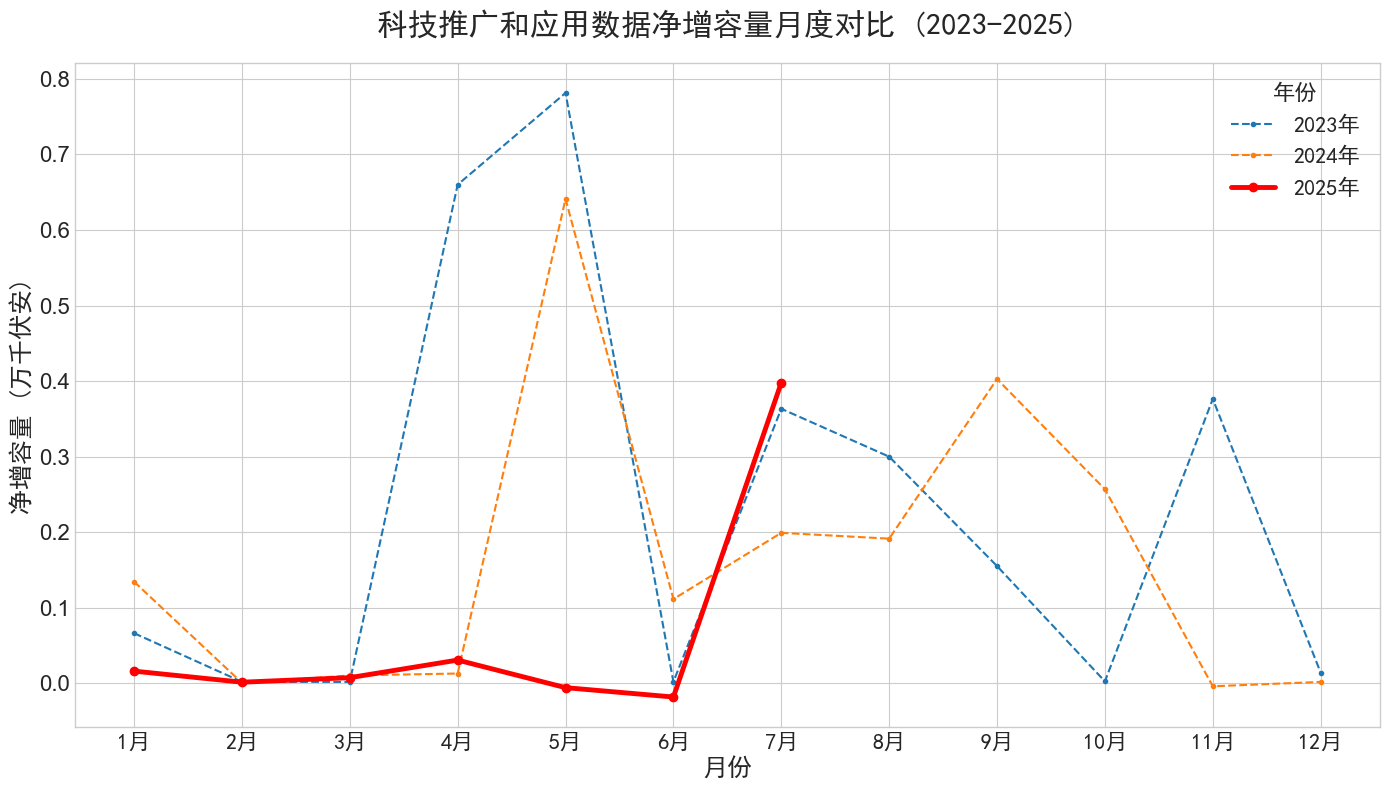

In [ ]:
#绘制不同行业的三年净增容量月度对比图

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Optional
from matplotlib import font_manager

# ==============================================================================
# 1. 配置层 (Configuration Layer)
# ==============================================================================
class Config:
    # --- 基本文件路径配置 ---
    BASE_PATH = Path(r'E:\A智网\业扩分析\8月分析\7月业扩月度报告')
    FILE_NEW_INC = BASE_PATH / '25年7月业扩报告_新装增容业扩.xlsx'
    FILE_DEC_TERM = BASE_PATH / '25年7月业扩报告_减容销户业扩.xlsx'
    OUTPUT_IMAGE_FILE = BASE_PATH / '近三年科技推广和应用数据净增容量月度对比图.png'

    # --- Excel工作表和目标分类配置 ---
    SHEET_TOTAL_INC_CAP = '完成新装增容_容量'
    SHEET_TOTAL_DEC_CAP = '完成减容销户_容量'
    TARGET_CATEGORY_NAME = '      其中：科技推广和应用服务业'
    
    # --- 图表文本配置 ---
    CHART_TITLE = '科技推广和应用数据净增容量月度对比 (2023-2025)'
    X_AXIS_LABEL = '月份'
    Y_AXIS_LABEL = '净增容量 (万千伏安)'

    # --- 绘图样式配置 ---
    LATEST_YEAR_LINEWIDTH = 3.5
    LATEST_YEAR_COLOR = 'red'
    OTHER_YEARS_LINEWIDTH = 1.5
    OTHER_YEARS_STYLE = '--'

    # ★★★★★ 新增：严格指定要使用的中文字体 ★★★★★
    TARGET_FONT = 'SimHei'

    # --- 字体大小配置 ---
    CHART_TITLE_FONTSIZE = 22
    AXIS_LABEL_FONTSIZE = 18
    TICK_LABEL_FONTSIZE = 16
    LEGEND_FONTSIZE = 16
    LEGEND_TITLE_FONTSIZE = 16


# ==============================================================================
# 2. 辅助函数层 (Helper Functions)
# ==============================================================================

# ★★★★★ 修改：函数现在只查找一个指定的字体，不再有备用方案 ★★★★★
def find_specific_font(font_name: str) -> Optional[font_manager.FontProperties]:
    """
    在系统中严格查找指定的字体文件，并返回其FontProperties对象。
    如果找不到，则返回None。
    """
    print(f"正在严格查找指定的字体: '{font_name}'...")
    
    font_files = font_manager.fontManager.ttflist
    for font_file in font_files:
        # 检查系统中的字体名是否与我们想要的完全匹配
        if font_file.name == font_name:
            print(f"成功找到字体 '{font_name}'，路径: {font_file.fname}")
            # 直接返回一个基于文件路径的FontProperties对象
            return font_manager.FontProperties(fname=font_file.fname)
            
    # 如果循环结束都没有找到
    print(f"[致命错误] 未能在系统中找到指定的字体 '{font_name}'。")
    print(f"         请确保 '{font_name}' (例如 '黑体') 字体已正确安装。")
    print("         程序无法继续。")
    return None

def read_and_calculate_net_increase(file_new_inc: Path, file_dec_term: Path, sheet_inc: str, sheet_dec: str) -> Optional[pd.DataFrame]:
    """读取并计算净增容量"""
    print("开始读取和计算净增容量数据...")
    try:
        df_inc = pd.read_excel(file_new_inc, sheet_name=sheet_inc, index_col='分类')
        df_dec = pd.read_excel(file_dec_term, sheet_name=sheet_dec, index_col='分类')
        common_cols = df_inc.columns.intersection(df_dec.columns)
        net_increase_df = df_inc[common_cols].subtract(df_dec[common_cols], fill_value=0)
        return net_increase_df.reset_index()
    except Exception as e:
        print(f"[致命错误] 读取或计算过程中发生错误: {e}")
        return None

# ==============================================================================
# 3. 主流程 (Main Logic)
# ==============================================================================
def main():
    """主执行函数"""
    
    # ★★★★★ 修改：调用新的函数，并从Config中获取字体名称 ★★★★★
    base_font_prop = find_specific_font(Config.TARGET_FONT)
    if base_font_prop is None:
        return
        
    font_path = base_font_prop.get_file()
    if not font_path:
        print("[致命错误] 无法从FontProperties对象中获取字体文件路径。")
        return
        
    # --- 为图表的不同部分创建带有指定大小的字体属性对象 ---
    title_font = font_manager.FontProperties(fname=font_path, size=Config.CHART_TITLE_FONTSIZE, weight='bold')
    axis_label_font = font_manager.FontProperties(fname=font_path, size=Config.AXIS_LABEL_FONTSIZE)
    tick_label_font = font_manager.FontProperties(fname=font_path, size=Config.TICK_LABEL_FONTSIZE)
    legend_text_font = font_manager.FontProperties(fname=font_path, size=Config.LEGEND_FONTSIZE)
    legend_title_font = font_manager.FontProperties(fname=font_path, size=Config.LEGEND_TITLE_FONTSIZE)
    
    print(f"\n开始生成可视化图表: {Config.CHART_TITLE}")
    
    # ... (数据处理部分保持不变) ...
    net_increase_df = read_and_calculate_net_increase(Config.FILE_NEW_INC, Config.FILE_DEC_TERM, Config.SHEET_TOTAL_INC_CAP, Config.SHEET_TOTAL_DEC_CAP)
    if net_increase_df is None: return
    total_industry_data = net_increase_df[net_increase_df['分类'].str.strip() == Config.TARGET_CATEGORY_NAME.strip()]
    if total_industry_data.empty: 
        print(f"[错误] 在Excel中未找到目标分类: '{Config.TARGET_CATEGORY_NAME}'。请检查名称是否完全匹配。")
        return
    long_df = total_industry_data.iloc[0].drop('分类').reset_index(); long_df.columns = ['年月', '净增容量']
    long_df['年月'] = long_df['年月'].astype(str); is_valid_yyyymm = long_df['年月'].str.match(r'^\d{6}$'); long_df = long_df[is_valid_yyyymm].copy()
    long_df['净增容量'] = pd.to_numeric(long_df['净增容量'], errors='coerce'); long_df['净增容量'] = long_df['净增容量'] / 10000
    long_df['年份'] = long_df['年月'].str[:4]; long_df['月份'] = long_df['年月'].str[4:].astype(int)
    target_years = ['2023', '2024', '2025']; long_df = long_df[long_df['年份'].isin(target_years)]
    plot_df = long_df.pivot(index='月份', columns='年份', values='净增容量')
    print("数据重塑完成，准备绘图..."); print(plot_df.head().round(2))

    # --- 绘图和美化 (此部分保持不变) ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))
    latest_year = '2025'
    for year in plot_df.columns:
        if year == latest_year:
            ax.plot(plot_df.index, plot_df[year], label=f'{year}年', linewidth=Config.LATEST_YEAR_LINEWIDTH, color=Config.LATEST_YEAR_COLOR, marker='o', markersize=6)
        else:
            ax.plot(plot_df.index, plot_df[year], label=f'{year}年', linewidth=Config.OTHER_YEARS_LINEWIDTH, linestyle=Config.OTHER_YEARS_STYLE, marker='.')

    ax.set_title(Config.CHART_TITLE, fontproperties=title_font, pad=20)
    ax.set_xlabel(Config.X_AXIS_LABEL, fontproperties=axis_label_font)
    ax.set_ylabel(Config.Y_AXIS_LABEL, fontproperties=axis_label_font)
    
    ax.set_xticks(range(1, 13))
    xticklabels = [f'{i}月' for i in range(1, 13)]
    ax.set_xticklabels(xticklabels, fontproperties=tick_label_font)
    ax.tick_params(axis='y', which='major', labelsize=Config.TICK_LABEL_FONTSIZE)
    
    legend = ax.legend(
        title='年份',
        prop=legend_text_font,
        title_fontproperties=legend_title_font
    )
    
    fig.tight_layout()
    try:
        plt.savefig(Config.OUTPUT_IMAGE_FILE, dpi=600)
        print(f"\n图表已成功保存到: {Config.OUTPUT_IMAGE_FILE}")
    except Exception as e:
        print(f"\n[错误] 保存图表失败: {e}")
    plt.show()

if __name__ == '__main__':
    main()